Country-Specific Success in Sports:

Dataset: "Country's Best Disciplines"
Visualization:
Bar chart showing the top 5 disciplines by medal count for each country.
Highlight dominant disciplines by medal types (Gold, Silver, Bronze).

In [37]:
import pandas as pd
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

# Load your datasets
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\Paris 2024 Summer Olympic Games Data analysis\Exported Data\Country's Best Disciplines.csv"
country_disciplines_df = pd.read_csv(file_path)

nocs_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\nocs.csv"
nocs_df = pd.read_csv(nocs_path)

# Perform the join to add ISO Alpha-3 codes
merged_df = pd.merge(
    country_disciplines_df,
    nocs_df[['country', 'code']],
    on='country',
    how='left'
)

# Drop unnecessary columns after the join
# merged_df = merged_df.drop(columns=['country_long'])
merged_df

,country,discipline,Gold_Medals,code
0,AIN,Trampoline Gymnastics,1,AIN
1,AIN,Tennis,0,AIN
2,AIN,Weightlifting,0,AIN
3,AIN,Rowing,0,AIN
4,Albania,Wrestling,0,ALB
...,...,...,...,...
485,Uzbekistan,Taekwondo,1,UZB
486,Uzbekistan,Judo,1,UZB
487,Uzbekistan,Wrestling,1,UZB
488,Uzbekistan,Weightlifting,0,UZB


In [38]:
# Prepare the data for the map
dominant_sports = merged_df.groupby(['country', 'discipline', 'code'], as_index=False)['Gold_Medals'].sum()

In [39]:
# Prepare the data: Count the number of dominant sports per country
dominant_sports_count = merged_df.groupby(['country', 'code'], as_index=False)['discipline'].count()
dominant_sports_count.rename(columns={'discipline': 'Dominant Sports Count'}, inplace=True)

# Debugging - Check if data exists
print("Dominant Sports Count:", dominant_sports_count.head())

# Create Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id='world-map',
        config={'scrollZoom': False},
    ),
    html.Hr(),
    html.Div(id='country-table', children=[
        html.H4("Click on a country to see its dominant sports"),
    ])
])

@app.callback(
    [Output('world-map', 'figure'),
     Output('country-table', 'children')],
    [Input('world-map', 'clickData')]
)
def update_map_and_table(click_data):
    # Build map
    fig = px.choropleth(
        dominant_sports_count,
        locations='code',
        color='Dominant Sports Count',
        hover_name='country',
        title="Number of Dominant Sports by Country",
        color_continuous_scale=px.colors.sequential.Plasma,
        projection="natural earth"
    )
    
    # Debugging - Check click data
    print("Click Data:", click_data)

    # Handle clickData
    if click_data:
        country_clicked = click_data['points'][0]['hovertext']
        filtered_data = merged_df[merged_df['country'] == country_clicked]

        # Debugging - Check filtered data
        print("Filtered Data:", filtered_data.head())

        # Create a table for the clicked country
        table = html.Table([
            html.Thead(html.Tr([html.Th("Sport"), html.Th("Gold Medals")])),
            html.Tbody([
                html.Tr([html.Td(row['discipline']), html.Td(row['Gold_Medals'])])
                for _, row in filtered_data.iterrows()
            ])
        ])
        table_title = html.H4(f"Dominant Sports for {country_clicked}")
        return fig, [table_title, table]
    else:
        return fig, [html.H4("Click on a country to see its dominant sports")]

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)

Dominant Sports Count:      country code  Dominant Sports Count
0        AIN  AIN                      4
1    Albania  ALB                      1
2    Algeria  ALG                      3
3  Argentina  ARG                      3
4    Armenia  ARM                      3


**Motivation Goals
The goal is to analyze how demographic factors such as age and gender impact medal success.**

In [40]:
import pandas as pd
import plotly.express as px

# Load datasets
athletes_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\athletes.csv"
athletes_df = pd.read_csv(athletes_path)

# Convert birth_date to datetime and calculate age
athletes_df['birth_date'] = pd.to_datetime(athletes_df['birth_date'], errors='coerce')
athletes_df['age'] = 2024 - athletes_df['birth_date'].dt.year

# Fill missing gender values
athletes_df['gender'] = athletes_df['gender'].fillna('Unknown')

medallists_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\medallists.csv"
medallists_df = pd.read_csv(medallists_path)

# Merge datasets with specified suffixes to avoid _x and _y
athlete_medals_df = pd.merge(
    medallists_df,
    athletes_df,
    left_on='name',
    right_on='name',
    how='inner',
    suffixes=('_medallist', '_athlete')  # Rename overlapping columns
)

# Keep relevant columns, including 'age'
athlete_medals_df = athlete_medals_df[[
    'name', 'gender_medallist', 'medal_type', 'discipline', 'age'
]]

# Rename columns for clarity
athlete_medals_df.rename(columns={
    'gender_medallist': 'gender'
}, inplace=True)

athlete_medals_df.to_csv("athlete_medals_df.csv", index=False)
# Group data for analysis
gender_medal_count = athlete_medals_df.groupby(['gender', 'medal_type'], as_index=False).size()
age_medal_count = athlete_medals_df.groupby(['age', 'medal_type'], as_index=False).size()

# Visualization 1: Medal Distribution by Gender
fig_gender = px.bar(
    gender_medal_count,
    x='medal_type',
    y='size',
    color='gender',
    title="Medal Distribution by Gender",
    labels={'size': 'Number of Medals', 'medal_type': 'Medal Type', 'gender': 'Gender'},
    barmode='group',  # Group bars by gender
    text='size'  # Show counts on bars
)

fig_gender.update_traces(textposition='outside')
fig_gender.update_layout(
    xaxis_title="Medal Type",
    yaxis_title="Number of Medals",
    legend_title="Gender",
    showlegend=True
)
fig_age = px.box(
    athlete_medals_df,
    x='medal_type',
    y='age',
    color='medal_type',
    title="Age Distribution by Medal Type",
    labels={'age': 'Age', 'medal_type': 'Medal Type'},
    points='all'  # Show individual data points
)

fig_age.update_layout(
    xaxis_title="Medal Type",
    yaxis_title="Age",
    showlegend=False
)

fig_age.show()

fig_gender.show()


In [41]:
import plotly.graph_objects as go

# Prepare data
gender_medal_pivot = gender_medal_count.pivot(index='medal_type', columns='gender', values='size').fillna(0)
gender_medal_pivot['Total'] = gender_medal_pivot.sum(axis=1)

# Create figure
fig = go.Figure()

# Add clustered columns for each gender
fig.add_trace(go.Bar(
    x=gender_medal_pivot.index,
    y=gender_medal_pivot['Male'],
    name='Male',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=gender_medal_pivot.index,
    y=gender_medal_pivot['Female'],
    name='Female',
    marker_color='orange'
))

# Add line for total medals
fig.add_trace(go.Scatter(
    x=gender_medal_pivot.index,
    y=gender_medal_pivot['Total'],
    name='Total',
    mode='lines+markers',
    line=dict(color='green', width=2),
    marker=dict(size=10)
))

# Update layout
fig.update_layout(
    title="Medal Distribution by Gender and Type",
    xaxis_title="Medal Type",
    yaxis_title="Number of Medals",
    barmode='group',
    legend_title="Category",
    template='plotly'
)

fig.show()


In [42]:
# Group by age ranges
athlete_medals_df['age_group'] = pd.cut(
    athlete_medals_df['age'], bins=[10, 20, 30, 40, 50, 60],
    labels=['10-20', '20-30', '30-40', '40-50', '50-60'], include_lowest=True
)
age_medal_count = athlete_medals_df.groupby(['age_group', 'medal_type'], as_index=False).size()
age_medal_pivot = age_medal_count.pivot(index='age_group', columns='medal_type', values='size').fillna(0)
age_medal_pivot['Total'] = age_medal_pivot.sum(axis=1)

# Create figure
fig_age = go.Figure()

# Add clustered columns for each medal type
for medal_type in ['Gold Medal', 'Silver Medal', 'Bronze Medal']:
    fig_age.add_trace(go.Bar(
        x=age_medal_pivot.index,
        y=age_medal_pivot[medal_type],
        name=medal_type
    ))

# Add line for total medals
fig_age.add_trace(go.Scatter(
    x=age_medal_pivot.index,
    y=age_medal_pivot['Total'],
    name='Total',
    mode='lines+markers',
    line=dict(color='red', width=2),
    marker=dict(size=10)
))

# Update layout
fig_age.update_layout(
    title="Age Distribution of Medalists by Medal Type",
    xaxis_title="Age Group",
    yaxis_title="Number of Medals",
    barmode='group',
    legend_title="Medal Type",
    template='plotly'
)

fig_age.show()


C:\Users\sreev\AppData\Local\Temp\ipykernel_45164\1264632063.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**Third Motivation**
**Dataset: "Medal Conversion Efficiency"**

Visualization Goal:

Scatter Plot: Display medals won vs. athletes sent, labeled by country, to highlight conversion rates (i.e., medals per athlete sent).
Objective:
Identify countries with high efficiency in converting athlete participation into medals.

In [43]:
import pandas as pd
import plotly.express as px

# Load datasets
athletes_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\athletes.csv"
total_medals_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\Paris 2024 Summer Olympic Games Data analysis\Exported Data\Total Medals by Country.csv"

athletes_df = pd.read_csv(athletes_path)
total_medals_df = pd.read_csv(total_medals_path)

# Step 1: Calculate Athletes Sent by Country
athletes_sent = athletes_df.groupby('country', as_index=False).size()
athletes_sent.rename(columns={'size': 'Athletes Sent', 'country': 'Country'}, inplace=True)

# Step 2: Calculate Total Medals Won by Country
total_medals_df['Medals Won'] = total_medals_df[['Gold', 'Silver', 'Bronze']].sum(axis=1)

# Rename 'country' in total_medals_df to 'Country' for consistency
total_medals_df.rename(columns={'country': 'Country'}, inplace=True)

# Perform the inner join
efficiency_df = pd.merge(
    athletes_sent,
    total_medals_df,
    on='Country',
    how='inner',
    suffixes=('_athletes', '_medals')
)
efficiency_df.head()
# Add a new column for Medals Won by summing Gold, Silver, and Bronze
efficiency_df['Medals Won'] = efficiency_df[['Gold', 'Silver', 'Bronze']].sum(axis=1)
efficiency_df.to_csv("efficiency_df.csv", index=False)
# Verify the updated dataframe
# print(efficiency_df.head())

# Proceed with the scatter plot
fig = px.scatter(
    efficiency_df,
    x='Athletes Sent',
    y='Medals Won',
    size='Medals Won',  # Bubble size represents medals won
    color='Medals Won',  # Color by total medals
    hover_name='Country',
    title="Medals Won vs. Athletes Sent (Conversion Efficiency)",
    labels={'Athletes Sent': 'Athletes Sent', 'Medals Won': 'Total Medals Won'}
)

# Update layout for clarity
fig.update_layout(
    xaxis_title="Number of Athletes Sent",
    yaxis_title="Total Medals Won",
    coloraxis_colorbar=dict(title="Total Medals Won"),
)

fig.show()


In [44]:
# Load noc dataset
noc_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\nocs.csv"
noc_df = pd.read_csv(noc_path)

# Preview noc dataset
print(noc_df.head())

# Rename columns in noc to match with efficiency_df
noc_df.rename(columns={'country': 'Country', 'code': 'ISO_Code'}, inplace=True)

# Perform join to get ISO codes
efficiency_df = pd.merge(efficiency_df, noc_df[['Country', 'ISO_Code']], on='Country', how='inner')

# Recalculate Conversion Rate (if not already present)
efficiency_df['Conversion Rate'] = efficiency_df['Medals Won'] / efficiency_df['Athletes Sent']

# Verify that the column exists
# Select the correct ISO code column and clean up
if 'ISO_Code_x' in efficiency_df.columns:
    efficiency_df['ISO_Code'] = efficiency_df['ISO_Code_x']
elif 'ISO_Code_y' in efficiency_df.columns:
    efficiency_df['ISO_Code'] = efficiency_df['ISO_Code_y']

# Drop extra columns if they exist
efficiency_df.drop(columns=['ISO_Code_x', 'ISO_Code_y'], errors='ignore', inplace=True)

# Verify the cleaned DataFrame
print(efficiency_df.columns)

# Create world map using the cleaned 'ISO_Code' column
fig = px.scatter_geo(
    efficiency_df,
    locations="ISO_Code",  # Use ISO country codes
    locationmode="ISO-3",  # Specify ISO-3 format
    size="Conversion Rate",  # Bubble size represents conversion rate
    color="Conversion Rate",  # Bubble color represents conversion rate
    hover_name="Country",  # Hover shows the country name
    hover_data={
        "Athletes Sent": True,
        "Medals Won": True,
        "Conversion Rate": ":.2f"
    },
    title="Conversion Rates by Country (Proportional Bubbles)",
    projection="natural earth",  # Natural earth projection
    color_continuous_scale=px.colors.sequential.Plasma  # Color gradient
)

# Update layout for better readability
fig.update_layout(
    title_x=0.5,  # Center the title
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    ),
    coloraxis_colorbar=dict(
        title="Conversion Rate",
        ticksuffix="%",
        len=0.5  # Adjust color bar height
    )
)

fig.show()


  code               country          country_long                   tag note
0  AFG           Afghanistan           Afghanistan           afghanistan    P
1  AHO  Netherlands Antilles  Netherlands Antilles  netherlands-antilles    H
2  AIN                   AIN                   AIN                   ain    P
3  ALB               Albania               Albania               albania    P
4  ALG               Algeria               Algeria               algeria    P
Index(['Country', 'Athletes Sent', 'Gold', 'Silver', 'Bronze', 'Medals Won',
       'ISO_Code', 'Conversion Rate'],
      dtype='object')


**Fourth Motivation: Comparative Event-Level Analysis**

**Objective: Perform a detailed analysis of specific events or disciplines, identifying key patterns and insights such as:**

Dominant countries in specific events.
Event-level medal trends.
Performance analysis of top athletes or teams.


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Load dataset
medals_by_event_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\Paris 2024 Summer Olympic Games Data analysis\Exported Data\Medals by Discipline.csv"
medals_by_event_df = pd.read_csv(medals_by_event_path)

# Bar Chart: Total Medals by Discipline
medals_by_event_df = medals_by_event_df.sort_values(by='total_medals', ascending=False)

fig = px.bar(
    medals_by_event_df,
    x='total_medals',
    y='discipline',
    orientation='h',
    color='total_medals',
    color_continuous_scale='Viridis',
    title='Total Medals by Discipline',
    labels={'total_medals': 'Total Medals', 'discipline': 'Discipline'}
)
fig.update_layout(
    xaxis=dict(title='Total Medals'),
    yaxis=dict(title='Discipline'),
    title_x=0.5
)
fig.show()

# Pie Chart: Percentage Contribution
medals_by_event_df['Percentage'] = (medals_by_event_df['total_medals'] / medals_by_event_df['total_medals'].sum()) * 100

# Group smaller contributions into "Other"
threshold = 2  # Percent threshold for grouping
medals_by_event_df['Category'] = medals_by_event_df['Percentage'].apply(lambda x: 'Other' if x < threshold else None)
medals_by_event_df['Category'] = medals_by_event_df['Category'].fillna(medals_by_event_df['discipline'])
grouped_df = medals_by_event_df.groupby('Category', as_index=False).sum()

# plt.figure(figsize=(8, 8))
# plt.pie(
#     grouped_df['Percentage'],
#     labels=grouped_df['Category'],
#     autopct='%1.1f%%',
#     startangle=140,
#     colors=sns.color_palette('pastel'),
# )
# plt.title('Percentage Contribution of Total Medals by Discipline', fontsize=16)
# plt.show()
fig = px.sunburst(
    medals_by_event_df,
    path=['discipline'],
    values='total_medals',
    title='Percentage Contribution of Total Medals by Discipline',
    color='total_medals',
    color_continuous_scale='Plasma',
)
fig.update_layout(title_x=0.5)
fig.show()


# Future Aspirations
max_medals = medals_by_event_df['total_medals'].max()
medals_by_event_df['Gap_to_Parity'] = max_medals - medals_by_event_df['total_medals']
medals_by_event_df['Projected_Growth'] = medals_by_event_df['Gap_to_Parity'] + medals_by_event_df['total_medals']

# Bar Chart: Projected Growth
# plt.figure(figsize=(12, 6))
# sns.barplot(data=medals_by_event_df, x='discipline', y='Projected_Growth', palette='coolwarm')
# plt.title('Projected Growth in Medals by Discipline', fontsize=16)
# plt.xlabel('Discipline', fontsize=12)
# plt.ylabel('Projected Growth', fontsize=12)
# plt.xticks(rotation=45, fontsize=9)
# # Add numbers on bars
# for i, v in enumerate(medals_by_event_df['Projected_Growth']):
#     plt.text(i, v + 5, str(int(v)), ha='center', fontsize=8)
# plt.tight_layout()
# plt.show()
growth_df = medals_by_event_df[['discipline', 'total_medals', 'Projected_Growth']].melt(
    id_vars='discipline',
    var_name='Metric',
    value_name='Count'
)

fig = px.bar(
    growth_df,
    x='discipline',
    y='Count',
    color='Metric',
    barmode='group',
    title='Current Totals vs. Projected Growth by Discipline',
    labels={'Count': 'Medal Count', 'discipline': 'Discipline'}
)
fig.update_layout(
    xaxis=dict(title='Discipline'),
    yaxis=dict(title='Medal Count'),
    title_x=0.5
)
fig.show()


# Save updated data to CSV
medals_by_event_df.to_csv('enhanced_medals_analysis.csv', index=False)
print("Enhanced analysis saved to 'enhanced_medals_analysis.csv'")


Enhanced analysis saved to 'enhanced_medals_analysis.csv'


In [46]:
import pandas as pd
import plotly.express as px

# Load the medalists.csv file
medalists_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\medallists.csv"
medalists_df = pd.read_csv(medalists_path)

# Group data by discipline and medal type
medal_counts = medalists_df.groupby(['discipline', 'medal_type'], as_index=False).size()

# Plot a clustered bar chart
fig = px.bar(
    medal_counts,
    x='discipline',
    y='size',
    color='medal_type',
    title='Medals by Type for Top Disciplines',
    labels={'size': 'Number of Medals', 'discipline': 'Discipline', 'medal_type': 'Medal Type'},
    barmode='group',  # Group bars side-by-side
    color_discrete_sequence=['gold', 'silver', 'brown'],  # Set medal colors
)

# Customize layout for better readability
fig.update_layout(
    xaxis=dict(title='Discipline', tickangle=45),
    yaxis=dict(title='Number of Medals'),
    title_x=0.5,  # Center the title
    legend_title='Medal Type',
    margin=dict(l=40, r=40, t=50, b=150),
)

# Show the figure
fig.show()

**Dominant Countries in Specific Events 2024**

In [47]:
import pandas as pd
import plotly.express as px
from ipywidgets import widgets

# Load the dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\Paris 2024 Summer Olympic Games Data analysis\Exported Data\Dominance in a Specific Event.csv"
dominance_df = pd.read_csv(file_path)

# Dropdown for event selection
events = sorted(dominance_df['event'].unique())
event_selector = widgets.Dropdown(
    options=events,
    description="Select Event:",
    layout=widgets.Layout(width='50%')
)

# Output widget for visualization
output = widgets.Output()

# Function to update visualization based on the selected event
def update_visualization(change):
    with output:
        clear_output(wait=True)  # Clear previous output
        selected_event = event_selector.value
        
        # Filter data for the selected event
        filtered_data = dominance_df[dominance_df['event'] == selected_event]
        
        # Create bar chart
        fig = px.bar(
            filtered_data,
            x='country',
            y='total_medals',
            title=f"Dominant Countries in {selected_event}",
            labels={'country': 'Country Name', 'total_medals': 'Total Medals'},
            text='total_medals',
            color='total_medals',
            color_continuous_scale='Viridis',
            hover_data=['Gold_Medals', 'Silver_Medals', 'Bronze_Medals']
        )
        
        fig.update_layout(
            xaxis_title="Country",
            yaxis_title="Number of Medals",
            xaxis_tickangle=45
        )
        fig.show()

# Observe dropdown changes
event_selector.observe(update_visualization, names='value')

# Display dropdown and output
display(event_selector, output)

Dropdown(description='Select Event:', layout=Layout(width='50%'), options=('10m Air Pistol Men', '10m Air Pist…

Output()

**Dominant Countries in Specific Events from 1896-2024**

In [48]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the data
data_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"  # Replace with your dataset path
# noc_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\nocs.csv"  # Replace with path to country codes dataset
df = pd.read_csv(data_path)
# Filter necessary columns
dominance_df = df[['Event', 'Team', 'Medal']]

# Calculate medal counts for each country in each event
dominant_countries = dominance_df.groupby(['Event', 'Team'])['Medal'].count().reset_index()
dominant_countries = dominant_countries.rename(columns={'Medal': 'Medal Count'})

# Get unique events
events = sorted(dominant_countries['Event'].unique())

# Dropdown for event selection
event_selector = widgets.Dropdown(
    options=events,
    description="Select Event:",
    layout=widgets.Layout(width='50%')
)

# Output widget for displaying the visualization
output = widgets.Output()

# Function to update visualization based on the selected event
def update_visualization(change):
    with output:
        clear_output(wait=True)  # Clear previous output completely
        selected_event = event_selector.value
        
        # Filter data for the selected event
        filtered_data = dominant_countries[dominant_countries['Event'] == selected_event]
        
        # Get top 10 countries by medal count
        top_countries = filtered_data.nlargest(10, 'Medal Count')
        
        # Create bar chart
        fig = px.bar(
            top_countries,
            x='Team',
            y='Medal Count',
            title=f"Top 10 Dominant Countries in {selected_event}",
            labels={'Team': 'Country Name', 'Medal Count': 'Number of Medals'},
            text_auto=True,
            color='Medal Count',
            color_continuous_scale='Viridis'
        )
        fig.update_layout(
            xaxis_title="Country",
            yaxis_title="Number of Medals",
            xaxis_tickangle=45
        )
        fig.show()

# Observe dropdown changes
event_selector.observe(update_visualization, names='value')

# Display dropdown and output
display(event_selector, output)



Dropdown(description='Select Event:', layout=Layout(width='50%'), options=('10m Air Pistol Men', '10m Air Pist…

Output()

**Event-Level Medal Trends 1896-2024**

In [49]:
# Ensure proper column naming and filtering
event_medal_df = df[['Year', 'Event', 'Medal']]

# Group and count medals by year and event
event_medal_trends = event_medal_df.groupby(['Year', 'Event'])['Medal'].count().reset_index()
event_medal_trends = event_medal_trends.rename(columns={'Medal': 'Number of Medals'})

# Get unique events for dropdown
events = sorted(event_medal_trends['Event'].unique())

# Dropdown for event selection
event_selector = widgets.Dropdown(
    options=events,
    description="Select Event:",
    layout=widgets.Layout(width='50%')
)

# Output widget for visualization
output = widgets.Output()

# Function to update visualization based on selected event
def update_event_trends(change):
    with output:
        clear_output(wait=True)  # Clear previous output
        selected_event = event_selector.value
        
        # Filter data for the selected event
        filtered_data = event_medal_trends[event_medal_trends['Event'] == selected_event]
        
        # Create a line chart
        fig = px.line(
            filtered_data,
            x='Year',
            y='Number of Medals',
            title=f"Medal Trends Over Time for {selected_event}",
            labels={'Year': 'Year', 'Number of Medals': 'Number of Medals'},
            markers=True,
            line_shape='spline'
        )
        fig.update_layout(
            xaxis_title="Year",
            yaxis_title="Number of Medals",
            xaxis=dict(tickmode='linear', tick0=1896, dtick=4),  # Ensure consistent ticks
            title_x=0.5  # Center title
        )
        fig.show()

# Observe dropdown changes
event_selector.observe(update_event_trends, names='value')

# Display widgets
display(event_selector, output)

Dropdown(description='Select Event:', layout=Layout(width='50%'), options=('10m Air Pistol Men', '10m Air Pist…

Output()

**Performance Analysis of Top Athletes**

In [57]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html, dash_table
from jupyter_dash import JupyterDash

# Load the dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\Paris 2024 Summer Olympic Games Data analysis\Exported Data\Top Athletes by Discipline.csv"
athletes_df = pd.read_csv(file_path)

# Initialize the app
app = JupyterDash(__name__)

# Dropdown options for unique events
event_options = [{"label": event, "value": event} for event in sorted(athletes_df['discipline'].unique())]

# App layout
app.layout = html.Div([
    html.H1("Top Athletes Performance by Event", style={'textAlign': 'center'}),
    
    dcc.Dropdown(
        id='event-dropdown',
        options=event_options,
        placeholder="Select an Event",
        style={'width': '50%', 'margin': 'auto'}
    ),
    
    html.Div(id='table-container')
])

# Callback to update table based on selected event
@app.callback(
    dash.dependencies.Output('table-container', 'children'),
    [dash.dependencies.Input('event-dropdown', 'value')]
)
def update_table(selected_event):
    if selected_event:
        # Filter the data for the selected event
        filtered_data = athletes_df[athletes_df['discipline'] == selected_event]
        
        # Create table
        table = dash_table.DataTable(
            id='athletes-table',
            columns=[
                {"name": "Discipline", "id": "discipline"},
                {"name": "Athlete Name", "id": "name"},
                {"name": "Country", "id": "country"},
                {"name": "Gold Medals", "id": "Gold_Medals"},
                {"name": "Silver Medals", "id": "Silver_Medals"},
                {"name": "Bronze Medals", "id": "Bronze_Medals"},
                {"name": "Total Medals", "id": "total_medals"}
            ],
            data=filtered_data.to_dict('records'),
            style_table={'overflowX': 'auto'},
            style_cell={'textAlign': 'left', 'padding': '5px'},
            style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'},
            page_size=10,  # Number of rows per page
            filter_action="native",  # Add filtering capability
            sort_action="native"  # Add sorting capability
        )
        return table
    return html.Div("Select an event to see the data.", style={'textAlign': 'center', 'marginTop': '20px'})

# Run the app
app.run_server(mode='inline', port=8054)



c:\Users\sreev\Data Visualization\Olympics 2024\olympics\Lib\site-packages\dash\dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



**Performance Analysis of Top Athletes/Teams 1886-2024**

In [51]:
data_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"  # Replace with your dataset path
# noc_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\nocs.csv"  # Replace with path to country codes dataset
df = pd.read_csv(data_path)
# Filter relevant columns and drop rows without medals
df_filtered = df[['Event', 'Name', 'Year', 'Medal', 'Team']].dropna(subset=['Medal'])

# Group by Event, Name, and Team, calculate the period and medal count
athlete_summary = df_filtered.groupby(['Event', 'Name', 'Team']).agg(
    Start_Year=('Year', 'min'),
    End_Year=('Year', 'max'),
    Medal_Count=('Medal', 'count')
).reset_index()

# Initialize Dash app
app = Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Medal Summary by Event", style={'textAlign': 'center'}),
    
    dcc.Dropdown(
        id='event-dropdown',
        options=[{"label": event, "value": event} for event in sorted(athlete_summary['Event'].unique())],
        placeholder="Select an Event",
        style={'width': '50%', 'margin': 'auto'}
    ),
    
    dash_table.DataTable(
        id='medal-table',
        columns=[
            {"name": "Event", "id": "Event", "type": "text"},
            {"name": "Athlete/Team Name", "id": "Name", "type": "text"},
            {"name": "Team (Country)", "id": "Team", "type": "text"},
            {"name": "Start Year", "id": "Start_Year", "type": "numeric"},
            {"name": "End Year", "id": "End_Year", "type": "numeric"},
            {"name": "Medal Count", "id": "Medal_Count", "type": "numeric"}
        ],
        data=[],  # Initially empty
        page_size=10,  # Number of rows per page
        filter_action="native",  # Enable filtering
        sort_action="native",  # Enable sorting
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={
            'textAlign': 'left',
            'padding': '5px',
            'font-family': 'Arial',
            'font-size': '14px'
        },
        style_header={
            'backgroundColor': 'lightblue',
            'fontWeight': 'bold',
            'textAlign': 'center'
        }
    )
])

# Callback to update table based on selected event
@app.callback(
    Output('medal-table', 'data'),
    [Input('event-dropdown', 'value')]
)
def update_table(selected_event):
    if selected_event:
        filtered_data = athlete_summary[athlete_summary['Event'] == selected_event]
        return filtered_data.to_dict('records')
    else:
        return athlete_summary.to_dict('records')  # Show all data if no event is selected

# Run app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

**Historical Trends**

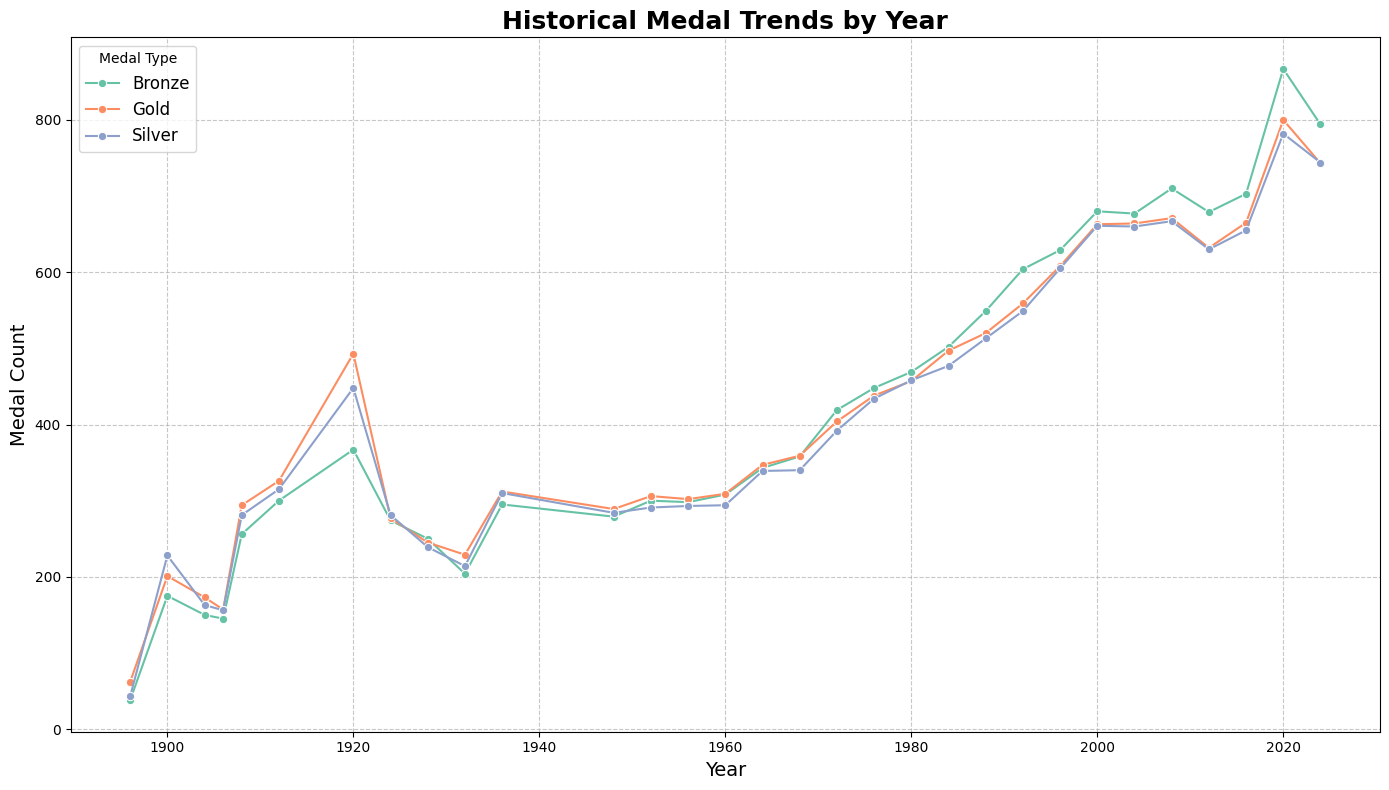

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
history_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(history_path)

# Filter and prepare the data
df_filtered = df[df["Medal"].notna()]  # Include rows with medals only
df_filtered = df_filtered[df_filtered["Medal"] != "No medal"]  # Remove "No medal"
df_grouped = df_filtered.groupby(["Year", "Medal"]).size().reset_index(name="Count")

# Enhanced Line Plot without "No medal"
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_grouped,
    x="Year",
    y="Count",
    hue="Medal",
    marker="o",
    palette="Set2",  # Use a distinct color palette
)
plt.title("Historical Medal Trends by Year", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Medal Count", fontsize=14)
plt.legend(title="Medal Type", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()



Explanation of the Visualization:
Trends in Medal Counts:

The plot displays the medal counts for Gold, Silver, and Bronze categories over time.
Noticeable growth in medal counts, especially after 1950, coincides with the increased number of events and participating nations in the Olympics.
Major Insights:

Early Years: Medal counts were significantly lower due to fewer events and limited global participation.
Growth Post-World War II: A substantial increase in medal counts around the 1950s reflects the inclusion of new events and the broader participation of countries.
Recent Olympics: Medal counts continue to rise, indicating the diversification and expansion of Olympic events.
Key Observations:

Peaks and troughs are evident during historical disruptions, such as World Wars or boycotts.
Gold medals typically lag slightly behind Silver and Bronze, likely due to the stringent criteria for the top podium position.

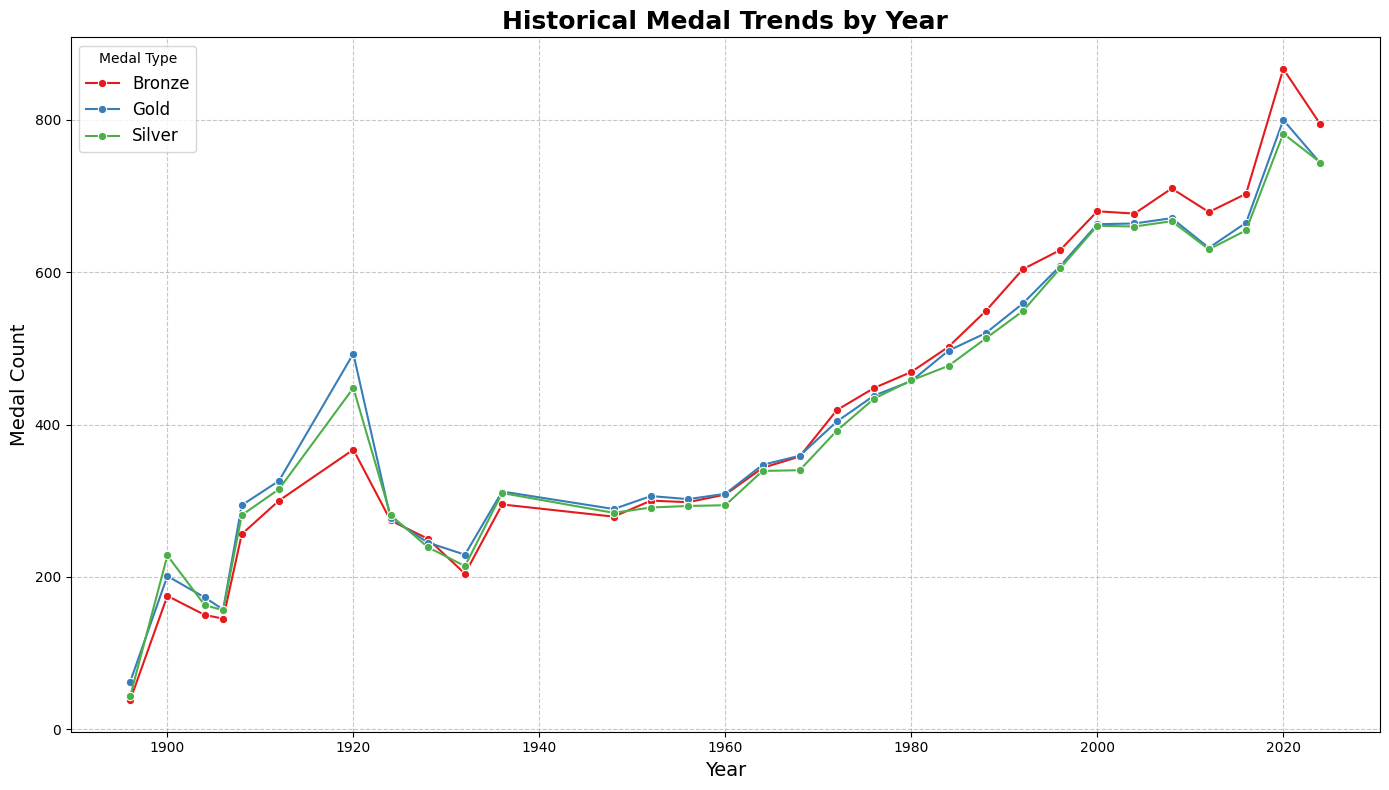

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
history_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(history_path)

# Filter out "No medal"
df_filtered = df[df['Medal'] != "No medal"]

# Group data by Year and Medal Type
df_grouped = df_filtered.groupby(['Year', 'Medal']).size().reset_index(name='Count')

# Create a line plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_grouped, x="Year", y="Count", hue="Medal", marker="o", palette="Set1")
plt.title("Historical Medal Trends by Year", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Medal Count", fontsize=14)
plt.legend(title="Medal Type", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



In [53]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output

# Load the dataset
data_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(data_path)

# Filter relevant columns and drop rows without gender or medals
df_filtered = df[['Event', 'Medal', 'Sex']].dropna(subset=['Sex', 'Medal'])

# Group by Event and Gender to count medals
gender_medal_counts = df_filtered.groupby(['Event', 'Sex']).size().reset_index(name='Medal Count')

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Medal Distribution by Gender", style={'textAlign': 'center'}),

    dcc.Dropdown(
        id='event-dropdown',
        options=[{"label": event, "value": event} for event in sorted(gender_medal_counts['Event'].unique())],
        placeholder="Select an Event",
        style={'width': '50%', 'margin': 'auto'}
    ),

    dcc.Graph(id='gender-bar-chart')
])

# Callback to update bar chart based on the selected event
@app.callback(
    Output('gender-bar-chart', 'figure'),
    [Input('event-dropdown', 'value')]
)
def update_bar_chart(selected_event):
    if selected_event:
        # Filter data for the selected event
        filtered_data = gender_medal_counts[gender_medal_counts['Event'] == selected_event]
    else:
        # Use the full dataset if no event is selected
        filtered_data = gender_medal_counts

    # Create bar chart
    fig = px.bar(
        filtered_data,
        x='Sex',
        y='Medal Count',
        color='Sex',
        title=f"Medal Distribution by Gender{' for ' + selected_event if selected_event else ''}",
        labels={'Sex': 'Gender', 'Medal Count': 'Number of Medals'},
        text='Medal Count',
        color_discrete_map={'M': 'blue', 'F': 'pink'}
    )
    fig.update_layout(xaxis_title="Gender", yaxis_title="Number of Medals", template="plotly_white")
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)


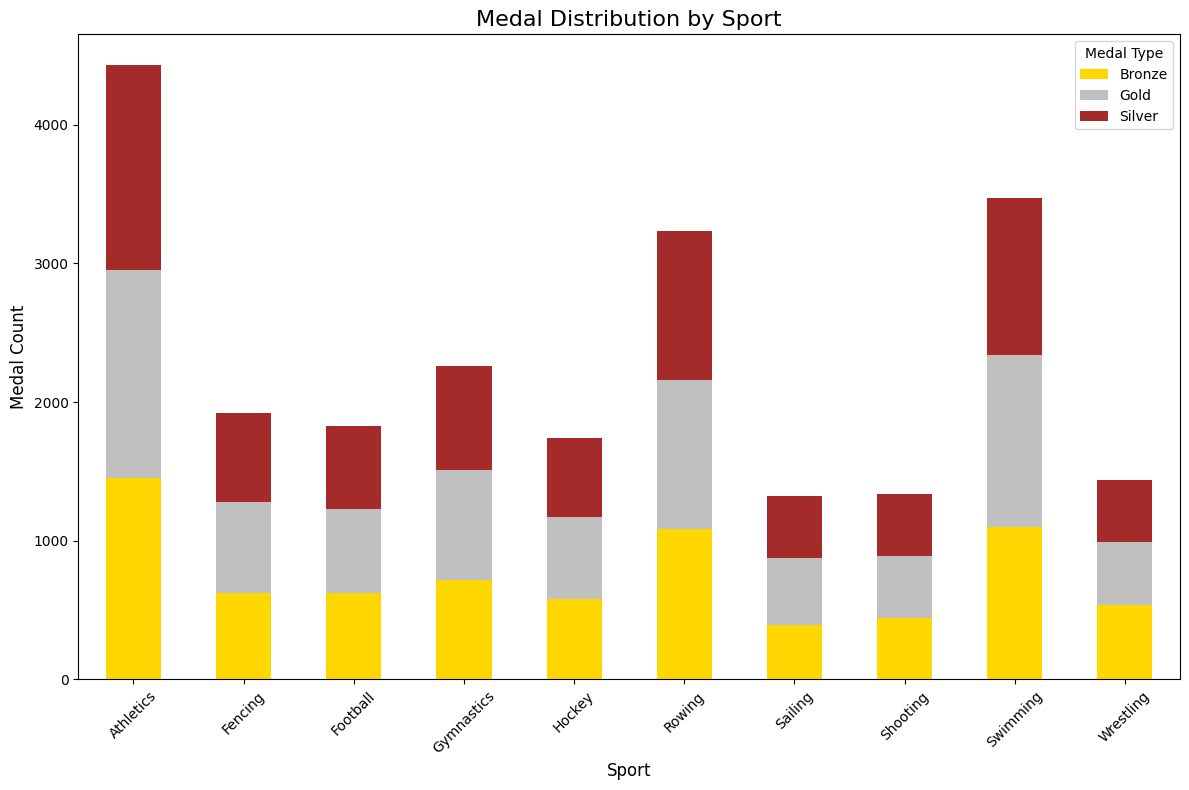

In [ ]:
# Group data by Sport and Medal Type
df_sport = df_filtered.groupby(['Sport', 'Medal']).size().reset_index(name='Count')

# Create a stacked bar plot for top sports
top_sports = df_sport.groupby('Sport')['Count'].sum().nlargest(10).index
df_top_sports = df_sport[df_sport['Sport'].isin(top_sports)]

df_pivot = df_top_sports.pivot(index="Sport", columns="Medal", values="Count").fillna(0)
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 8), color=['gold', 'silver', 'brown'])
plt.title("Medal Distribution by Sport", fontsize=16)
plt.xlabel("Sport", fontsize=12)
plt.ylabel("Medal Count", fontsize=12)
plt.legend(title="Medal Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


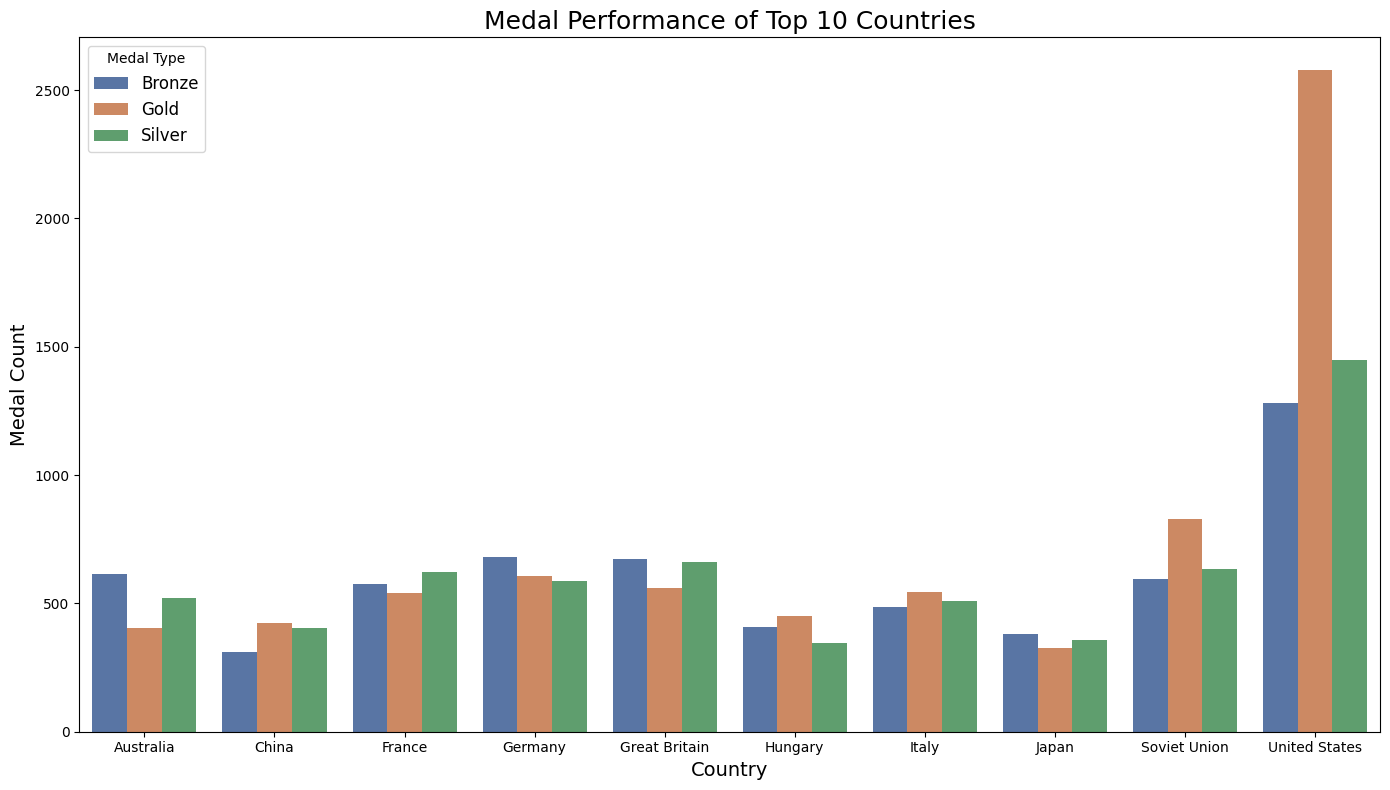

In [ ]:
# Group data by Country and Medal Type
df_country_medals = df_filtered.groupby(['Team', 'Medal']).size().reset_index(name='Count')

# Create a bar plot for top 10 countries
top_countries = df_country_medals.groupby('Team')['Count'].sum().nlargest(10).index
df_top_countries = df_country_medals[df_country_medals['Team'].isin(top_countries)]

plt.figure(figsize=(14, 8))
sns.barplot(data=df_top_countries, x="Team", y="Count", hue="Medal", palette="deep")
plt.title("Medal Performance of Top 10 Countries", fontsize=18)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Medal Count", fontsize=14)
plt.legend(title="Medal Type", fontsize=12)
plt.tight_layout()
plt.show()


In [54]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Load dataset
history_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(history_path)

# Filter out "No medal"
# Filter out "No medal" and ensure valid years
df_filtered = df[(df['Medal'] != "No medal") & (df['Year'].notna())]

# Create Widgets
trend_selector = widgets.Dropdown(
    options=["Overall Medal Trends", "Country-Specific Trends", "Gender Distribution", "Medal Distribution by Sport"],
    value="Country-Specific Trends",
    description="Trend Type:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

country_selector = widgets.Dropdown(
    options=sorted(df_filtered['Team'].dropna().unique()),
    description="Select Country:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

# Define a function to update visualizations
def update_visualizations(change):
    output.clear_output()
    with output:
        if trend_selector.value == "Country-Specific Trends":
            selected_country = country_selector.value
            df_country = df_filtered[df_filtered['Team'] == selected_country]
            
            if df_country.empty:
                print(f"No data available for {selected_country}")
                return

            df_country_grouped = df_country.groupby(['Year', 'Medal']).size().reset_index(name='Count')
            fig = px.line(
                df_country_grouped,
                x='Year',
                y='Count',
                color='Medal',
                title=f"Medal Trends for {selected_country} by Year",
                markers=True
            )
            fig.update_layout(xaxis_title="Year", yaxis_title="Medal Count", legend_title="Medal Type")
            fig.show()

        elif trend_selector.value == "Overall Medal Trends":
            df_grouped = df_filtered.groupby(['Year', 'Medal']).size().reset_index(name='Count')
            fig = px.line(
                df_grouped,
                x='Year',
                y='Count',
                color='Medal',
                title="Overall Medal Trends by Year",
                markers=True
            )
            fig.update_layout(xaxis_title="Year", yaxis_title="Medal Count", legend_title="Medal Type")
            fig.show()

        elif trend_selector.value == "Gender Distribution":
            df_gender = df_filtered.groupby(['Sex', 'Medal']).size().reset_index(name='Count')
            fig = px.bar(
                df_gender,
                x='Sex',
                y='Count',
                color='Medal',
                barmode='stack',
                title="Medal Distribution by Gender"
            )
            fig.update_layout(xaxis_title="Gender", yaxis_title="Medal Count", legend_title="Medal Type")
            fig.show()

        elif trend_selector.value == "Medal Distribution by Sport":
            df_sport = df_filtered.groupby(['Sport', 'Medal']).size().reset_index(name='Count')
            top_sports = df_sport.groupby('Sport')['Count'].sum().nlargest(10).index
            df_top_sports = df_sport[df_sport['Sport'].isin(top_sports)]
            fig = px.bar(
                df_top_sports,
                x='Sport',
                y='Count',
                color='Medal',
                barmode='stack',
                title="Medal Distribution by Sport (Top 10)"
            )
            fig.update_layout(xaxis_title="Sport", yaxis_title="Medal Count", legend_title="Medal Type")
            fig.show()

# Attach the function to the dropdown
trend_selector.observe(update_visualizations, names='value')

# Layout the widgets
display(trend_selector)

# Display the country selector only for "Country-Specific Trends"
def update_country_selector(change):
    if trend_selector.value == "Country-Specific Trends":
        display(country_selector)
    else:
        country_selector.close()

trend_selector.observe(update_country_selector, names='value')

# Output widget for plots
display(output)

Dropdown(description='Trend Type:', index=1, layout=Layout(width='50%'), options=('Overall Medal Trends', 'Cou…

Output()

In [55]:
from IPython.display import clear_output

# Data Cleaning
# Data Cleaning
df['Team'] = df['Team'].str.strip()  # Remove extra spaces
df_filtered = df[(df['Medal'] != "No medal") & (df['Year'].notna()) & (df['Team'].notna())]

# Get unique countries for dropdown
countries = sorted(df_filtered['Team'].dropna().unique())

# Widgets
trend_selector = widgets.Dropdown(
    options=["Overall Medal Trends", "Country-Specific Trends"],
    value="Country-Specific Trends",
    description="Trend Type:",
    layout=widgets.Layout(width='50%')
)

country_selector = widgets.Dropdown(
    options=countries,
    description="Select Country:",
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

# Visualization Update Function
def update_trends(change):
    with output:
        clear_output(wait=True)  # Clear previous outputs
        if trend_selector.value == "Country-Specific Trends":
            selected_country = country_selector.value
            country_data = df_filtered[df_filtered['Team'] == selected_country]
            
            if country_data.empty:
                print(f"No data available for {selected_country}.")
                return
            
            # Group data by Year and Medal
            country_grouped = country_data.groupby(['Year', 'Medal']).size().reset_index(name='Count')
            
            # Create Line Plot
            fig = px.line(
                country_grouped,
                x='Year',
                y='Count',
                color='Medal',
                title=f"Medal Trends for {selected_country} by Year",
                markers=True
            )
            fig.update_layout(
                xaxis_title="Year",
                yaxis_title="Medal Count",
                legend_title="Medal Type",
                template="plotly_white"
            )
            fig.show()

        elif trend_selector.value == "Overall Medal Trends":
            overall_grouped = df_filtered.groupby(['Year', 'Medal']).size().reset_index(name='Count')
            fig = px.line(
                overall_grouped,
                x='Year',
                y='Count',
                color='Medal',
                title="Overall Medal Trends by Year",
                markers=True
            )
            fig.update_layout(
                xaxis_title="Year",
                yaxis_title="Medal Count",
                legend_title="Medal Type",
                template="plotly_white"
            )
            fig.show()

# Observers
trend_selector.observe(update_trends, names='value')
country_selector.observe(update_trends, names='value')

# Display Widgets
display(trend_selector, country_selector, output)

Dropdown(description='Trend Type:', index=1, layout=Layout(width='50%'), options=('Overall Medal Trends', 'Cou…

Dropdown(description='Select Country:', layout=Layout(width='50%'), options=('A North American Team', 'AIN', '…

Output()

In [ ]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Load dataset
history_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(history_path)


0          Basketball Men's Basketball
1         Judo Men's Extra-Lightweight
2              Football Men's Football
3          Tug-Of-War Men's Tug-Of-War
4         Athletics Women's 100 metres
                      ...             
252560                    Women's 100m
252561          Women's Freestyle 50kg
252562            4 x 400m Relay Mixed
252563                    Jumping Team
252564            Men's 4 x 400m Relay
Name: Event, Length: 252565, dtype: object


In [66]:
# Get distinct values from the 'sports' column
unique_sports = df['Sport'].unique()

# Display unique sports
print("Distinct Sports:", unique_sports)

# Count the number of unique sports
print(f"Total distinct sports: {len(unique_sports)}")

Distinct Sports: ['Basketball' 'Judo' 'Football' 'Tug-Of-War' 'Athletics' 'Swimming'
 'Badminton' 'Sailing' 'Gymnastics' 'Art Competitions' 'Handball'
 'Weightlifting' 'Wrestling' 'Water Polo' 'Hockey' 'Rowing' 'Fencing'
 'Equestrianism' 'Shooting' 'Boxing' 'Taekwondo' 'Cycling' 'Diving'
 'Canoeing' 'Tennis' 'Modern Pentathlon' 'Golf' 'Softball' 'Archery'
 'Volleyball' 'Synchronized Swimming' 'Table Tennis' 'Baseball'
 'Rhythmic Gymnastics' 'Rugby Sevens' 'Trampolining' 'Beach Volleyball'
 'Triathlon' 'Rugby' 'Lacrosse' 'Polo' 'Cricket' 'Ice Hockey' 'Racquets'
 'Motorboating' 'Croquet' 'Figure Skating' 'Jeu De Paume' 'Roque'
 'Basque Pelota' 'Alpinism' 'Aeronautics' 'Cycling Road'
 'Artistic Gymnastics' 'Karate' 'Baseball/Softball'
 'Trampoline Gymnastics' 'Marathon Swimming' 'Canoe Slalom' 'Surfing'
 'Canoe Sprint' 'Cycling BMX Racing' 'Equestrian' 'Artistic Swimming'
 'Cycling Track' 'Skateboarding' 'Cycling Mountain Bike' '3x3 Basketball'
 'Cycling BMX Freestyle' 'Sport Climbing' 'M

In [67]:
sports_to_category = {
    # Ball Games
    'Basketball': 'Ball Games',
    '3x3 Basketball': 'Ball Games',
    'Football': 'Ball Games',
    'Handball': 'Ball Games',
    'Water Polo': 'Ball Games',
    'Volleyball': 'Ball Games',
    'Beach Volleyball': 'Ball Games',
    'Rugby Sevens': 'Ball Games',
    'Rugby': 'Ball Games',
    'Lacrosse': 'Ball Games',
    'Polo': 'Ball Games',
    'Cricket': 'Ball Games',
    'Softball': 'Ball Games',
    'Baseball': 'Ball Games',
    'Baseball/Softball': 'Ball Games',

    # Racket Sports
    'Badminton': 'Racket Sports',
    'Tennis': 'Racket Sports',
    'Table Tennis': 'Racket Sports',
    'Jeu De Paume': 'Racket Sports',
    'Racquets': 'Racket Sports',

    # Power Sports
    'Weightlifting': 'Power Sports',
    'Wrestling': 'Power Sports',

    # Speed Sports
    'Athletics': 'Speed Sports',
    'Swimming': 'Speed Sports',
    'Cycling': 'Speed Sports',
    'Cycling Road': 'Speed Sports',
    'Cycling Track': 'Speed Sports',
    'Cycling BMX Racing': 'Speed Sports',
    'Cycling BMX Freestyle': 'Speed Sports',
    'Cycling Mountain Bike': 'Speed Sports',
    'Triathlon': 'Speed Sports',

    # Endurance Sports
    'Marathon Swimming': 'Endurance Sports',
    'Rowing': 'Endurance Sports',
    'Canoeing': 'Endurance Sports',
    'Canoe Slalom': 'Endurance Sports',
    'Canoe Sprint': 'Endurance Sports',

    # Combat Sports
    'Boxing': 'Combat Sports',
    'Judo': 'Combat Sports',
    'Taekwondo': 'Combat Sports',
    'Karate': 'Combat Sports',

    # Artistic Sports
    'Gymnastics': 'Artistic Sports',
    'Artistic Gymnastics': 'Artistic Sports',
    'Rhythmic Gymnastics': 'Artistic Sports',
    'Trampolining': 'Artistic Sports',
    'Artistic Swimming': 'Artistic Sports',
    'Synchronized Swimming': 'Artistic Sports',
    'Figure Skating': 'Artistic Sports',

    # Precision Sports
    'Archery': 'Precision Sports',
    'Shooting': 'Precision Sports',
    'Golf': 'Precision Sports',

    # Aquatic Sports
    'Diving': 'Aquatic Sports',
    'Surfing': 'Aquatic Sports',

    # Equestrian
    'Equestrian': 'Equestrian',
    'Equestrianism': 'Equestrian',

    # Miscellaneous or Other
    'Modern Pentathlon': 'Other',
    'Tug-Of-War': 'Other',
    'Art Competitions': 'Other',
    'Motorboating': 'Other',
    'Croquet': 'Other',
    'Roque': 'Other',
    'Basque Pelota': 'Other',
    'Aeronautics': 'Other',
    'Alpinism': 'Other',
    'Breaking': 'Other',
    'Skateboarding': 'Other',
    'Sport Climbing': 'Other',

    # Combined Sports
    'Cycling Road, Cycling Track': 'Combined Sports',
    'Cycling Road, Cycling Mountain Bike': 'Combined Sports',
    'Cycling Road, Triathlon': 'Combined Sports',
    '3x3 Basketball, Basketball': 'Combined Sports',
    'Marathon Swimming, Swimming': 'Combined Sports'
}


In [69]:
# Apply mapping to categorize sports
df['Category'] = df['Sport'].map(sports_to_category).fillna('Uncategorized')

# Display unique sports with categories
unique_sports_with_categories = df[['Sport', 'Category']].drop_duplicates()
print(unique_sports_with_categories)

# Save updated dataset
df.to_csv("categorized_olympics_sports.csv", index=False)
print("Categorized dataset saved!")


                                      Sport         Category
0                                Basketball       Ball Games
1                                      Judo    Combat Sports
2                                  Football       Ball Games
3                                Tug-Of-War            Other
4                                 Athletics     Speed Sports
...                                     ...              ...
238336                             Breaking            Other
239538          Cycling Road, Cycling Track  Combined Sports
241922  Cycling Road, Cycling Mountain Bike  Combined Sports
246480              Cycling Road, Triathlon  Combined Sports
247411           3x3 Basketball, Basketball  Combined Sports

[76 rows x 2 columns]
Categorized dataset saved!


In [109]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Output, Input

# Load the dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\Paris 2024 Summer Olympic Games Data analysis\Exported Data\categorized_olympics_sports.csv"
df = pd.read_csv(file_path)

# Initialize Dash app
app = Dash(__name__)

# Create dropdown options for categories
categories = df['Category'].unique()
category_options = [{"label": category, "value": category} for category in sorted(categories)]

# App layout
app.layout = html.Div([
    html.H1("Olympics Performance by Category", style={'textAlign': 'center'}),
    
    # Dropdown for category selection
    dcc.Dropdown(
        id='category-dropdown',
        options=category_options,
        placeholder="Select a Category",
        style={'width': '50%', 'margin': 'auto'}
    ),
    
    # Bar chart for top countries
    dcc.Graph(id='top-countries-chart'),
    
    # Insights
    html.Div(id='category-insights', style={'textAlign': 'center', 'marginTop': '20px', 'fontSize': '16px'})
])

@app.callback(
    [Output('top-countries-chart', 'figure'),
     Output('category-insights', 'children')],
    [Input('category-dropdown', 'value')]
)
def update_visualization(selected_category):
    if selected_category:
        # Filter data for the selected category
        filtered_data = df[df['Category'] == selected_category]

        # Aggregate data to get total medals by Team
        team_medals = filtered_data.groupby('Team')['Medal'].count().reset_index()
        team_medals = team_medals.rename(columns={'Medal': 'Total Medals'})

        # Get top 10 teams
        top_teams = team_medals.nlargest(10, 'Total Medals')

        # Create bar chart
        fig = px.bar(
            top_teams,
            x='Team',
            y='Total Medals',
            title=f"Top 10 Teams in {selected_category}",
            text='Total Medals',
            color='Total Medals',
            color_continuous_scale='Viridis'
        )
        fig.update_layout(
            xaxis_title="Team",
            yaxis_title="Total Medals",
            xaxis_tickangle=45
        )

        # Generate insight
        top_team = top_teams.iloc[0]['Team']
        total_medals = top_teams.iloc[0]['Total Medals']
        first_year = filtered_data['Year'].min()
        last_year = filtered_data['Year'].max()
        insight = (
            f"{top_team} has been the top performer in {selected_category} with {total_medals} medals, "
            f"excelling from {first_year} to {last_year}."
        )
        
        return fig, insight
    else:
        return {}, "Select a category to view insights and data."


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


**Host Country Dominance**

In [73]:
# Get distinct values from the 'sports' column
host_city = df['City'].unique()

# Display unique sports
print("Distinct City:", host_city)

# Count the number of unique sports
print(f"Total distinct Hosts: {len(host_city)}")

Distinct City: ['Barcelona' 'London' 'Antwerpen' 'Paris' 'Los Angeles' 'Helsinki'
 'Sydney' 'Atlanta' 'Stockholm' 'Beijing' 'Rio de Janeiro' 'Athina'
 'Mexico City' 'Munich' 'Seoul' 'Berlin' 'Melbourne' 'Roma' 'Amsterdam'
 'Montreal' 'Moskva' 'Tokyo' 'St. Louis']
Total distinct Hosts: 23


In [106]:
import pandas as pd

# Load the Olympics dataset
file_path = "C:/Users/sreev/Data Visualization/Olympics 2024/olympics_dataset_1896-2024.csv"  # Replace with your dataset path
olympics_df = pd.read_csv(file_path)

# Filter relevant columns
relevant_columns = ['Year', 'Team', 'Medal']
filtered_df = olympics_df[relevant_columns]

# Count medals by Year and Team
medals_by_year_df = (
    filtered_df[filtered_df['Medal'].notna()]  # Consider only rows where Medal is not null
    .groupby(['Year', 'Team'])
    .size()  # Use size to count occurrences
    .reset_index(name='Medals Won')  # Rename the count column
)

# Sort values by Year and Medals Won
medals_by_year_df = medals_by_year_df.sort_values(by=['Year', 'Medals Won'], ascending=[True, False]).reset_index(drop=True)

# Display the resulting DataFrame
print(medals_by_year_df)

# Optionally, save to a CSV file
medals_by_year_df.to_csv('medals_by_year.csv', index=False)


      Year           Team  Medals Won
0     1896         Greece         140
1     1896        Germany          93
2     1896  United States          27
3     1896         France          26
4     1896  Great Britain          23
...    ...            ...         ...
4521  2024         Tuvalu           2
4522  2024         Belize           1
4523  2024  Liechtenstein           1
4524  2024          Nauru           1
4525  2024        Somalia           1

[4526 rows x 3 columns]


In [108]:
medals_by_year_df[(medals_by_year_df['Year']==2024)& (medals_by_year_df['Team']=='United States')]

,Year,Team,Medals Won
4320,2024,United States,854


In [ ]:
# Load dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(file_path)

# Host city to country mapping
host_city_country_mapping = {
    'Barcelona': 'Spain',
    'London': 'United Kingdom',
    'Antwerpen': 'Belgium',
    'Paris': 'France',
    'Los Angeles': 'United States',
    'Helsinki': 'Finland',
    'Sydney': 'Australia',
    'Atlanta': 'United States',
    'Stockholm': 'Sweden',
    'Beijing': 'China',
    'Rio de Janeiro': 'Brazil',
    'Athina': 'Greece',
    'Mexico City': 'Mexico',
    'Munich': 'Germany',
    'Seoul': 'South Korea',
    'Berlin': 'Germany',
    'Melbourne': 'Australia',
    'Roma': 'Italy',
    'Amsterdam': 'Netherlands',
    'Montreal': 'Canada',
    'Moskva': 'Russia',
    'Tokyo': 'Japan',
    'St. Louis': 'United States'
}

# Add host country column
df['Host_Country'] = df['City'].map(host_city_country_mapping)



,player_id,Name,Sex,Team,NOC,Year,Season,City,Sport,Event,Medal,Host_Country
0,0,A Dijiang,M,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,Spain
1,1,A Lamusi,M,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,United Kingdom
2,2,Gunnar Aaby,M,Denmark,DEN,1920,Summer,Antwerpen,Football,Football Men's Football,No medal,Belgium
3,3,Edgar Aabye,M,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,France
4,26,Cornelia (-strannood),F,Netherlands,NED,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,No medal,United States
...,...,...,...,...,...,...,...,...,...,...,...,...
252560,4986655,Sefora Ada,F,Equatorial Guinea,GEQ,2024,Summer,Paris,Athletics,Women's 100m,No medal,France
252561,9460001,Emanuela Liuzzi,F,Italy,ITA,2024,Summer,Paris,Wrestling,Women's Freestyle 50kg,No medal,France
252562,1972077,Isayah Boers,M,Netherlands,NED,2024,Summer,Paris,Athletics,4 x 400m Relay Mixed,Gold,France
252563,1899865,Kevin Staut,M,France,FRA,2024,Summer,Paris,Equestrian,Jumping Team,Bronze,France


In [95]:
# Merging the dataframes
merged_df = pd.merge(
    medals_by_year_df,  # The medals by team and year dataframe
    df[['Year', 'City', 'Host_Country']].drop_duplicates(),  # Extracting unique Year-City-Host Country mapping
    on='Year',
    how='left'
)

# Rearranging columns for clarity
merged_df = merged_df[['Year', 'Team', 'Medals Won', 'Host_Country']]

# Display the merged dataframe
print(merged_df)

# Optionally, save to a CSV file
merged_df.to_csv('medals_with_host_country.csv', index=False)

      Year           Team  Medals Won Host_Country
0     1896         Greece         140       Greece
1     1896        Germany          93       Greece
2     1896  United States          27       Greece
3     1896         France          26       Greece
4     1896  Great Britain          23       Greece
...    ...            ...         ...          ...
4643  2024         Tuvalu           2       France
4644  2024         Belize           1       France
4645  2024  Liechtenstein           1       France
4646  2024          Nauru           1       France
4647  2024        Somalia           1       France

[4648 rows x 4 columns]


In [105]:
merged_df[(merged_df["Year"]==2024)&(merged_df['Team']=='United States')]

,Year,Team,Medals Won,Host_Country
4442,2024,United States,854,France


In [103]:
# Filter rows where the Team matches the Host_Country
host_country_medals_df = merged_df[merged_df['Team'] == merged_df['Host_Country']][['Year', 'Host_Country', 'Medals Won']].copy()

# Drop duplicates to ensure only unique year and host country medal counts are included
host_country_medals_df = host_country_medals_df.drop_duplicates(subset=['Year', 'Host_Country'])

# Rename columns for clarity
host_country_medals_df.rename(columns={'Medals Won': 'Total_Medals'}, inplace=True)

# Sort by Year for better readability
host_country_medals_df = host_country_medals_df.sort_values(by='Year').reset_index(drop=True)

# Display the resulting dataframe
print(host_country_medals_df)

# Optionally, save to a CSV file
host_country_medals_df.to_csv('host_country_medals_by_year.csv', index=False)


    Year   Host_Country  Total_Medals
0   1896         Greece           140
1   1900         France           679
2   1904  United States           823
3   1906         Greece           318
4   1912         Sweden           614
5   1920        Belgium           488
6   1924         France           620
7   1928    Netherlands           373
8   1932  United States           724
9   1936        Germany           567
10  1952        Finland           399
11  1956      Australia           402
12  1956         Sweden           180
13  1960          Italy           392
14  1964          Japan           446
15  1968         Mexico           446
16  1976         Canada           531
17  1984  United States           693
18  1988    South Korea           547
19  1992          Spain           537
20  1996  United States           827
21  2000      Australia           762
22  2004         Greece           495
23  2008          China           708
24  2016         Brazil           571
25  2020    

In [74]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output

# Load dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(file_path)

# Host city to country mapping
host_city_country_mapping = {
    'Barcelona': 'Spain',
    'London': 'United Kingdom',
    'Antwerpen': 'Belgium',
    'Paris': 'France',
    'Los Angeles': 'United States',
    'Helsinki': 'Finland',
    'Sydney': 'Australia',
    'Atlanta': 'United States',
    'Stockholm': 'Sweden',
    'Beijing': 'China',
    'Rio de Janeiro': 'Brazil',
    'Athina': 'Greece',
    'Mexico City': 'Mexico',
    'Munich': 'Germany',
    'Seoul': 'South Korea',
    'Berlin': 'Germany',
    'Melbourne': 'Australia',
    'Roma': 'Italy',
    'Amsterdam': 'Netherlands',
    'Montreal': 'Canada',
    'Moskva': 'Russia',
    'Tokyo': 'Japan',
    'St. Louis': 'United States'
}

# Add host country column
df['Host_Country'] = df['City'].map(host_city_country_mapping)

# Filter rows where the country is the host
host_performance = df[df['Host_Country'] == df['Team']]

# Aggregate medal counts for each host country
host_analysis = host_performance.groupby(['Host_Country', 'Year']).agg(
    Gold_Medals=('Medal', lambda x: (x == 'Gold').sum()),
    Silver_Medals=('Medal', lambda x: (x == 'Silver').sum()),
    Bronze_Medals=('Medal', lambda x: (x == 'Bronze').sum()),
    Total_Medals=('Medal', 'count')
).reset_index()

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Host Country Medal Performance", style={'textAlign': 'center'}),
    dcc.Dropdown(
        id='host-country-dropdown',
        options=[{'label': country, 'value': country} for country in host_analysis['Host_Country'].unique()],
        placeholder="Select Host Country",
        style={'width': '50%', 'margin': 'auto'}
    ),
    html.Div(id='host-country-table')
])

# Callback to update table based on selected host country
@app.callback(
    Output('host-country-table', 'children'),
    [Input('host-country-dropdown', 'value')]
)
def update_table(selected_country):
    if selected_country:
        filtered_data = host_analysis[host_analysis['Host_Country'] == selected_country]
        table = dash_table.DataTable(
            id='host-country-performance-table',
            columns=[
                {"name": "Year", "id": "Year"},
                {"name": "Gold Medals", "id": "Gold_Medals"},
                {"name": "Silver Medals", "id": "Silver_Medals"},
                {"name": "Bronze Medals", "id": "Bronze_Medals"},
                {"name": "Total Medals", "id": "Total_Medals"}
            ],
            data=filtered_data.to_dict('records'),
            style_table={'overflowX': 'auto'},
            style_cell={'textAlign': 'left', 'padding': '5px'},
            style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'},
            page_size=10,
            filter_action="native",
            sort_action="native"
        )
        return table
    return html.Div("Select a host country to see the data.", style={'textAlign': 'center', 'marginTop': '20px'})

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


In [75]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load the dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(file_path)

# Map cities to host countries
host_country_map = {
    "Barcelona": "Spain", "London": "United Kingdom", "Antwerpen": "Belgium",
    "Paris": "France", "Los Angeles": "United States", "Helsinki": "Finland",
    "Sydney": "Australia", "Atlanta": "United States", "Stockholm": "Sweden",
    "Beijing": "China", "Rio de Janeiro": "Brazil", "Athina": "Greece",
    "Mexico City": "Mexico", "Munich": "Germany", "Seoul": "South Korea",
    "Berlin": "Germany", "Melbourne": "Australia", "Roma": "Italy",
    "Amsterdam": "Netherlands", "Montreal": "Canada", "Moskva": "Russia",
    "Tokyo": "Japan", "St. Louis": "United States"
}

# Add host country column
df['Host_Country'] = df['City'].map(host_country_map)

# Filter for host country medals
host_analysis = df[df['Team'] == df['Host_Country']].groupby(['Year', 'Host_Country']).agg(
    Total_Medals=('Medal', 'count'),
    Gold_Medals=('Medal', lambda x: (x == 'Gold').sum()),
    Silver_Medals=('Medal', lambda x: (x == 'Silver').sum()),
    Bronze_Medals=('Medal', lambda x: (x == 'Bronze').sum())
).reset_index()

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Host Country Performance Analysis", style={'textAlign': 'center'}),
    
    dcc.Graph(id='host-performance-chart'),
    
    dcc.Dropdown(
        id='host-country-dropdown',
        options=[{"label": country, "value": country} for country in host_analysis['Host_Country'].unique()],
        placeholder="Select a Host Country",
        style={'width': '50%', 'margin': 'auto'}
    )
])

@app.callback(
    Output('host-performance-chart', 'figure'),
    [Input('host-country-dropdown', 'value')]
)
def update_chart(selected_country):
    if selected_country:
        filtered_data = host_analysis[host_analysis['Host_Country'] == selected_country]
        fig = px.bar(
            filtered_data,
            x='Year',
            y=['Gold_Medals', 'Silver_Medals', 'Bronze_Medals', 'Total_Medals'],
            title=f"Medal Performance for {selected_country} as Host",
            labels={'value': 'Number of Medals', 'variable': 'Medal Type'},
            barmode='group',
            text_auto=True
        )
        fig.update_layout(
            xaxis_title="Year",
            yaxis_title="Number of Medals",
            legend_title="Medal Type"
        )
        return fig
    return px.bar(title="Select a host country to see its performance.")

if __name__ == '__main__':
    app.run_server(debug=True)


In [76]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load the dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(file_path)

# Map cities to host countries
host_country_map = {
    "Barcelona": "Spain", "London": "United Kingdom", "Antwerpen": "Belgium",
    "Paris": "France", "Los Angeles": "United States", "Helsinki": "Finland",
    "Sydney": "Australia", "Atlanta": "United States", "Stockholm": "Sweden",
    "Beijing": "China", "Rio de Janeiro": "Brazil", "Athina": "Greece",
    "Mexico City": "Mexico", "Munich": "Germany", "Seoul": "South Korea",
    "Berlin": "Germany", "Melbourne": "Australia", "Roma": "Italy",
    "Amsterdam": "Netherlands", "Montreal": "Canada", "Moskva": "Russia",
    "Tokyo": "Japan", "St. Louis": "United States"
}

# Add host country column
df['Host_Country'] = df['City'].map(host_country_map)

# Aggregate medal counts by year and country
country_year_medals = df.groupby(['Year', 'Team']).agg(
    Total_Medals=('Medal', 'count'),
    Gold_Medals=('Medal', lambda x: (x == 'Gold').sum()),
    Silver_Medals=('Medal', lambda x: (x == 'Silver').sum()),
    Bronze_Medals=('Medal', lambda x: (x == 'Bronze').sum())
).reset_index()

# Get best-performing country for each year
best_countries = country_year_medals.loc[
    country_year_medals.groupby('Year')['Total_Medals'].idxmax()
].rename(columns={
    'Team': 'Best_Country',
    'Total_Medals': 'Best_Country_Medals'
})[['Year', 'Best_Country', 'Best_Country_Medals']]

# Merge host country data with best-performing country data
host_comparison = df[df['Team'] == df['Host_Country']].groupby(['Year', 'Host_Country']).agg(
    Host_Total_Medals=('Medal', 'count')
).reset_index()

host_vs_best = pd.merge(
    host_comparison, best_countries, on='Year', how='inner'
)

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Host Country vs Best-Performing Country Analysis", style={'textAlign': 'center'}),
    
    dcc.Graph(id='host-vs-best-chart'),
    
    dcc.Dropdown(
        id='year-dropdown',
        options=[{"label": year, "value": year} for year in host_vs_best['Year'].unique()],
        placeholder="Select a Year",
        style={'width': '50%', 'margin': 'auto'}
    )
])

@app.callback(
    Output('host-vs-best-chart', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_chart(selected_year):
    if selected_year:
        filtered_data = host_vs_best[host_vs_best['Year'] == selected_year]
        fig = px.bar(
            filtered_data.melt(
                id_vars=['Year', 'Host_Country', 'Best_Country'],
                value_vars=['Host_Total_Medals', 'Best_Country_Medals'],
                var_name='Category', value_name='Medals'
            ),
            x='Category',
            y='Medals',
            color='Category',
            text='Medals',
            title=f"Comparison of Host ({filtered_data.iloc[0]['Host_Country']}) vs Best-Performing Country ({filtered_data.iloc[0]['Best_Country']}) in {selected_year}",
            labels={'Category': 'Country Role', 'Medals': 'Number of Medals'}
        )
        fig.update_layout(
            xaxis_title="Country Role",
            yaxis_title="Number of Medals",
            legend_title="Role",
            showlegend=False
        )
        return fig
    return px.bar(title="Select a year to see comparison.")

if __name__ == '__main__':
    app.run_server(debug=True)


In [78]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load the dataset
file_path = r"C:\Users\sreev\Data Visualization\Olympics 2024\olympics_dataset_1896-2024.csv"
df = pd.read_csv(file_path)

# Map cities to host countries
host_country_map = {
    "Barcelona": "Spain", "London": "United Kingdom", "Antwerpen": "Belgium",
    "Paris": "France", "Los Angeles": "United States", "Helsinki": "Finland",
    "Sydney": "Australia", "Atlanta": "United States", "Stockholm": "Sweden",
    "Beijing": "China", "Rio de Janeiro": "Brazil", "Athina": "Greece",
    "Mexico City": "Mexico", "Munich": "Germany", "Seoul": "South Korea",
    "Berlin": "Germany", "Melbourne": "Australia", "Roma": "Italy",
    "Amsterdam": "Netherlands", "Montreal": "Canada", "Moskva": "Russia",
    "Tokyo": "Japan", "St. Louis": "United States"
}

# Add host country column
df['Host_Country'] = df['City'].map(host_country_map)

# Filter out rows without medals
df_medals = df[df['Medal'].notna()]

# Aggregate medal counts by year and team
year_country_medals = df_medals.groupby(['Year', 'Team']).agg(
    Total_Medals=('Medal', 'count'),
    Gold_Medals=('Medal', lambda x: (x == 'Gold').sum()),
    Silver_Medals=('Medal', lambda x: (x == 'Silver').sum()),
    Bronze_Medals=('Medal', lambda x: (x == 'Bronze').sum())
).reset_index()

# Extract the host country performance for each year
host_performance = df_medals.groupby(['Year', 'Host_Country']).agg(
    Host_Total_Medals=('Medal', 'count')
).reset_index().rename(columns={'Host_Country': 'Country'})

# Identify the best-performing country for each year
best_performance = year_country_medals.loc[
    year_country_medals.groupby('Year')['Total_Medals'].idxmax()
][['Year', 'Team', 'Total_Medals']].rename(columns={'Team': 'Best_Country', 'Total_Medals': 'Best_Country_Medals'})

# Merge the host and best-performing country data
comparison_df = pd.merge(host_performance, best_performance, on='Year', how='inner')

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Host Country vs Best-Performing Country in Specific Olympic Years", style={'textAlign': 'center'}),
    
    dcc.Graph(id='host-vs-best-chart'),
    
    dcc.Dropdown(
        id='year-dropdown',
        options=[{"label": year, "value": year} for year in comparison_df['Year'].unique()],
        placeholder="Select an Olympic Year",
        style={'width': '50%', 'margin': 'auto'}
    )
])

@app.callback(
    Output('host-vs-best-chart', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_chart(selected_year):
    if selected_year:
        filtered_data = comparison_df[comparison_df['Year'] == selected_year]
        melted_data = filtered_data.melt(
            id_vars=['Year', 'Country', 'Best_Country'],
            value_vars=['Host_Total_Medals', 'Best_Country_Medals'],
            var_name='Role', value_name='Total_Medals'
        )
        fig = px.bar(
            melted_data,
            x='Role',
            y='Total_Medals',
            color='Role',
            text='Total_Medals',
            title=f"Host ({filtered_data.iloc[0]['Country']}) vs Best-Performing Country ({filtered_data.iloc[0]['Best_Country']}) in {selected_year}",
            labels={'Role': 'Country Role', 'Total_Medals': 'Number of Medals'}
        )
        fig.update_layout(
            xaxis_title="Country Role",
            yaxis_title="Number of Medals",
            legend_title="Role",
            showlegend=False
        )
        return fig
    return px.bar(title="Select a year to see comparison.")

if __name__ == '__main__':
    app.run_server(debug=True)
